Importation de la df demande d'électricité française

In [60]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pandas as pd
import holidays 
from workalendar.europe import France 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm

In [40]:
df_fr_demand = pd.read_csv("C:/Users/axell/OneDrive/Documents/ENSAE/StatApp/data/france_data/power_demand.csv",sep=";",skiprows=14)
df_fr_demand.head()

,Timestamp start (Europe/Paris),Timestamp end (Europe/Paris),Power demand forecast Meteologica France (GW),Power demand observation France (GW)
0,01/01/2023 00:00,01/01/2023 01:00,44.01,45.62
1,01/01/2023 01:00,01/01/2023 02:00,42.26,45.61
2,01/01/2023 02:00,01/01/2023 03:00,41.56,44.85
3,01/01/2023 03:00,01/01/2023 04:00,38.49,41.91
4,01/01/2023 04:00,01/01/2023 05:00,36.56,39.45


Nettoyage de la df

In [10]:
print(df_fr_demand.columns)

Index(['Timestamp start (Europe/Paris)', 'Timestamp end (Europe/Paris)',
       'Power demand forecast Meteologica France (GW)',
       'Power demand observation France (GW)'],
      dtype='object')


In [41]:
df_fr_demand = df_fr_demand.rename(columns={
    "Timestamp start (Europe/Paris)" : "start",
    "Timestamp end (Europe/Paris)" : "end",
    'Power demand forecast Meteologica France (GW)' : "forecast",
    'Power demand observation France (GW)' : "observation"
})

In [42]:
df_fr_demand["start"] = pd.to_datetime(df_fr_demand["start"], format="%d/%m/%Y %H:%M")
df_fr_demand["end"] = pd.to_datetime(df_fr_demand["end"], format="%d/%m/%Y %H:%M")

In [43]:
print(df_fr_demand.isnull().sum())
df_fr_demand = df_fr_demand.dropna()

start           0
end             0
forecast        0
observation    62
dtype: int64


Analyse descriptive de la df

In [8]:
print(df_fr_demand['start'].min())
print(df_fr_demand['end'].max())

2023-01-01 00:00:00
2024-12-01 00:00:00


In [18]:
df_fr_demand.describe()

,start,end,forecast,observation
count,16738,16738,16738.000000,16738.000000
mean,2023-12-16 20:01:11.406380800,2023-12-16 21:01:11.836539648,48.231979,48.253615
min,2023-01-01 00:00:00,2023-01-01 01:00:00,27.780000,28.770000
25%,2023-06-24 09:15:00,2023-06-24 10:15:00,41.190000,41.312500
50%,2023-12-16 18:30:00,2023-12-16 19:30:00,46.890000,46.900000
75%,2024-06-09 14:45:00,2024-06-09 15:45:00,53.730000,53.807500
max,2024-11-30 23:00:00,2024-12-01 00:00:00,81.030000,83.170000
std,NaN,NaN,9.748281,9.737320


In [30]:
rmse = np.sqrt(mean_squared_error(df_fr_demand["observation"], df_fr_demand["forecast"]))
print(f"RMSE: {rmse:.2f} GW")

RMSE: 1.31 GW


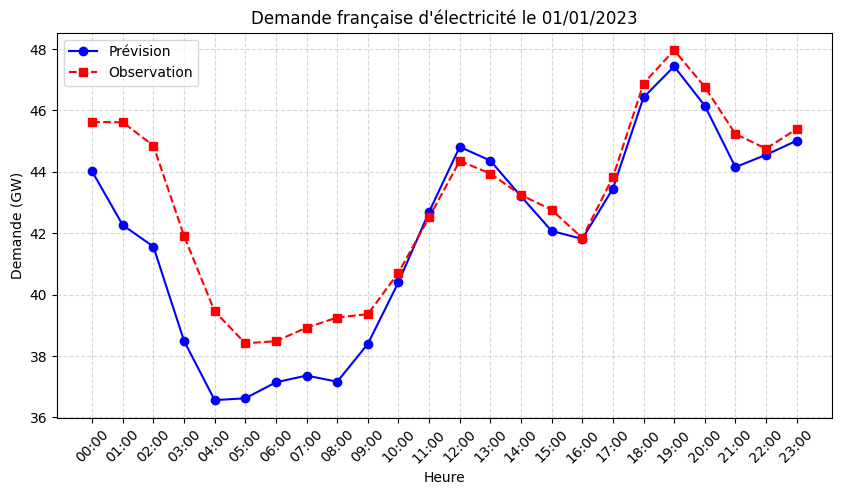

In [24]:
def plot_day(date_str):
    """
    Affiche la courbe des prévisions et observations pour un jour donné.
    :param date_str: Date au format "JJ/MM/AAAA"
    """

    day_data = df_fr_demand[df_fr_demand["start"].dt.strftime("%d/%m/%Y") == date_str]
    
    # Vérifier si des données existent pour ce jour-là
    if day_data.empty:
        print(f"Aucune donnée pour la date {date_str}.")
        return
    
    # Tracer les courbes
    plt.figure(figsize=(10, 5))
    plt.plot(day_data["start"], day_data["forecast"], label="Prévision", color="blue", marker="o")
    plt.plot(day_data["start"], day_data["observation"], label="Observation", color="red", linestyle="dashed", marker="s")

    # Personnalisation du graphique
    plt.xlabel("Heure")
    plt.ylabel("Demande (GW)")
    plt.title(f"Demande française d'électricité le {date_str}")
    plt.xticks(day_data["start"], day_data["start"].dt.strftime("%H:%M"), rotation=45)  # Afficher uniquement les heures
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

    # Afficher le graphique
    plt.show()

plot_day("01/01/2023")


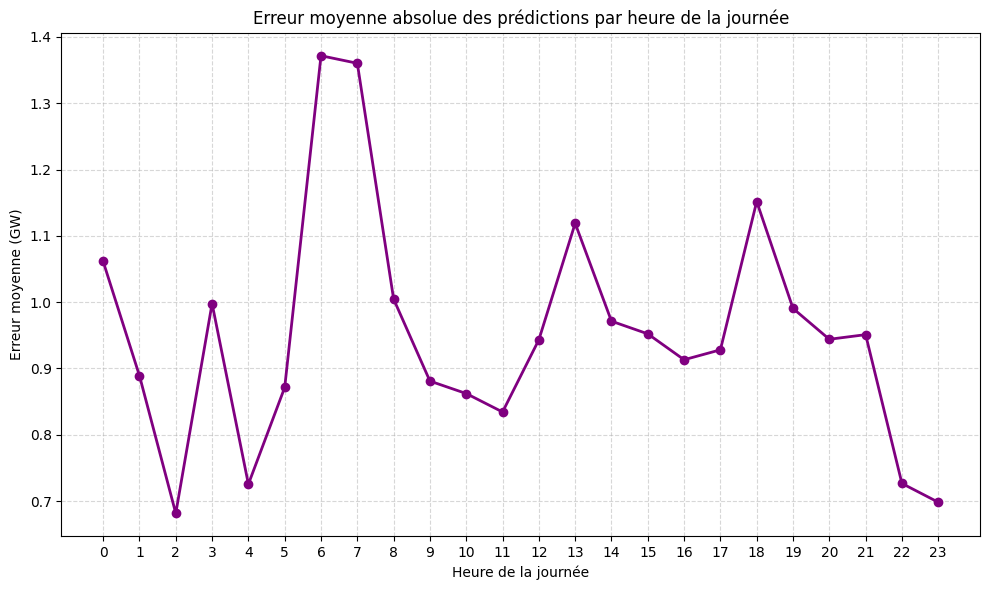

In [33]:
# Calculer l'erreur absolue (entre prévision et observation)
df_fr_demand["error"] = abs(df_fr_demand["forecast"] - df_fr_demand["observation"])

df_fr_demand["hour"] = df_fr_demand["start"].dt.hour

# Calculer la moyenne de l'erreur pour chaque heure
hourly_error = df_fr_demand.groupby("hour")["error"].mean()

# Tracer l'erreur moyenne par heure
plt.figure(figsize=(10, 6))
plt.plot(hourly_error.index, hourly_error.values, marker='o', color='purple', linestyle='-', linewidth=2)

plt.title("Erreur moyenne absolue des prédictions par heure de la journée")
plt.xlabel("Heure de la journée")
plt.ylabel("Erreur moyenne (GW)")
plt.xticks(range(24))  
plt.grid(True, linestyle="--", alpha=0.5)

# Afficher le graphique
plt.tight_layout()
plt.show()


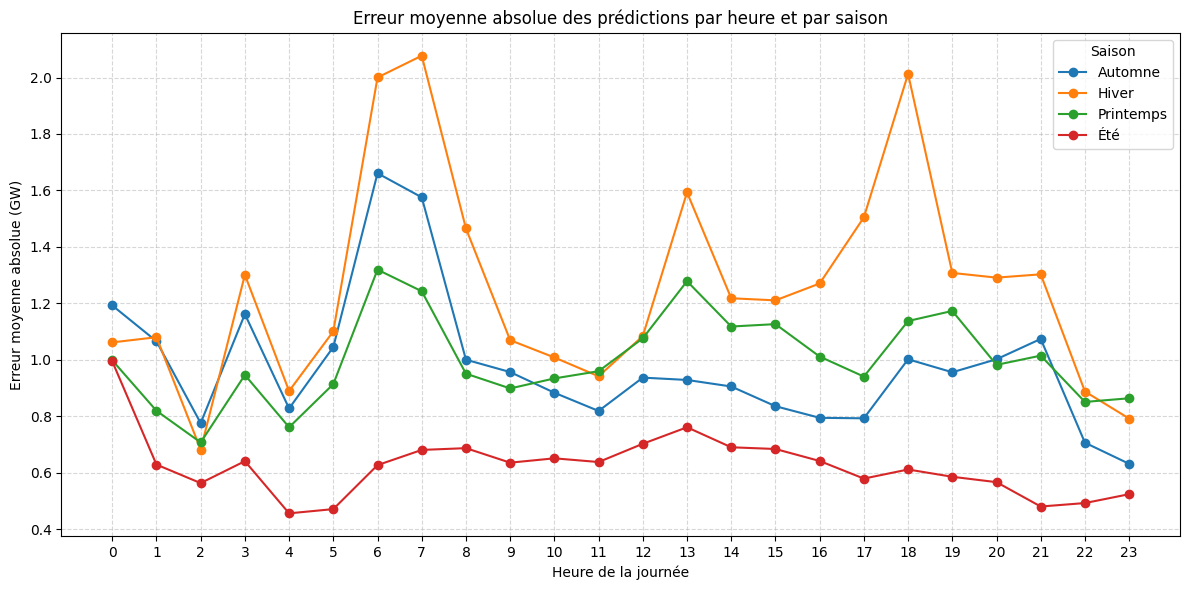

In [34]:
# Extraire l'heure et le mois de la journée
df_fr_demand["hour"] = df_fr_demand["start"].dt.hour
df_fr_demand["month"] = df_fr_demand["start"].dt.month

# Ajouter une colonne "saison" pour catégoriser les mois en fonction des saisons
def assign_season(month):
    if month in [12, 1, 2]:
        return "Hiver"
    elif month in [3, 4, 5]:
        return "Printemps"
    elif month in [6, 7, 8]:
        return "Été"
    else:
        return "Automne"

df_fr_demand["season"] = df_fr_demand["month"].apply(assign_season)

# Calculer l'erreur moyenne par heure et par saison
seasonal_hourly_error = df_fr_demand.groupby(["season", "hour"])["error"].mean().unstack()

# Tracer les courbes pour chaque saison
plt.figure(figsize=(12, 6))

for season in seasonal_hourly_error.index:
    plt.plot(seasonal_hourly_error.columns, seasonal_hourly_error.loc[season], label=season, marker='o')

plt.title("Erreur moyenne absolue des prédictions par heure et par saison")
plt.xlabel("Heure de la journée")
plt.ylabel("Erreur moyenne absolue (GW)")
plt.xticks(range(24)) 
plt.legend(title="Saison")
plt.grid(True, linestyle="--", alpha=0.5)

# Afficher le graphique
plt.tight_layout()
plt.show()


Amélioration des valeurs prédites à l'aide des vacances et jours fériés

In [36]:
start_date = "2023-01-01"
end_date = "2024-12-01"
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Charger les jours fériés en France
fr_holidays = holidays.France(years=[2023, 2024])

# Créer un DataFrame avec une colonne 'date'
df_calendar = pd.DataFrame({'date': date_range})

# Ajouter une colonne "jour_férié" (True si c'est un jour férié, sinon False)
df_calendar['jour_férié'] = df_calendar['date'].apply(lambda x: x in fr_holidays)

#Ajouter une colonne "WE"
df_calendar['weekend'] = df_calendar['date'].dt.weekday >= 5

print(df_calendar.head(10))

        date  jour_férié  weekend
0 2023-01-01        True     True
1 2023-01-02       False    False
2 2023-01-03       False    False
3 2023-01-04       False    False
4 2023-01-05       False    False
5 2023-01-06       False    False
6 2023-01-07       False     True
7 2023-01-08       False     True
8 2023-01-09       False    False
9 2023-01-10       False    False


In [52]:
# Créer une colonne "date" avec la date seule, mais en format datetime64
df_fr_demand['date'] = pd.to_datetime(df_fr_demand['start'].dt.date)

# Fusionner les deux DataFrames sur la colonne 'date'
df_fr_demand_merge = df_fr_demand.merge(df_calendar, on="date", how="left")

# Créer une colonne "autres" qui indique si ce n'est ni un jour férié ni un week-end
df_fr_demand_merge['autres'] = ~df_fr_demand_merge['jour_férié'] & ~df_fr_demand_merge['weekend']

# Vérifier le résultat
print(df_fr_demand_merge.head())

                start                 end  forecast  observation       date  \
0 2023-01-01 00:00:00 2023-01-01 01:00:00     44.01        45.62 2023-01-01   
1 2023-01-01 01:00:00 2023-01-01 02:00:00     42.26        45.61 2023-01-01   
2 2023-01-01 02:00:00 2023-01-01 03:00:00     41.56        44.85 2023-01-01   
3 2023-01-01 03:00:00 2023-01-01 04:00:00     38.49        41.91 2023-01-01   
4 2023-01-01 04:00:00 2023-01-01 05:00:00     36.56        39.45 2023-01-01   

   jour_férié  weekend  autres  
0        True     True   False  
1        True     True   False  
2        True     True   False  
3        True     True   False  
4        True     True   False  


In [57]:
# Calculer l'erreur pour chaque catégorie : jour férié, week-end, autres
df_fr_demand_merge['erreur'] = abs(df_fr_demand_merge['forecast'] - df_fr_demand_merge['observation'])

# Moyenne des erreurs selon les catégories
print(df_fr_demand_merge.groupby('jour_férié')['erreur'].mean())
print(df_fr_demand_merge.groupby('weekend')['erreur'].mean())
print(df_fr_demand_merge.groupby('autres')['erreur'].mean())

jour_férié
False    0.948768
True     1.031171
Name: erreur, dtype: float64
weekend
False    0.964789
True     0.916977
Name: erreur, dtype: float64
autres
False    0.925880
True     0.962594
Name: erreur, dtype: float64


In [59]:
# Sélectionner les variables explicatives (features)
X = df_fr_demand_merge[['forecast', 'jour_férié', 'weekend']]  
y = df_fr_demand_merge['observation']

# Diviser en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner un modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# Prédire
y_pred = model.predict(X_test)

# Évaluer l'amélioration
print("Erreur avant amélioration :", mean_absolute_error(X_test['forecast'], y_test))  # Erreur pour les prévisions de base
print("Erreur après amélioration :", mean_absolute_error(y_pred, y_test))  # Erreur après modèle avec jour férié et week-end


Erreur avant amélioration : 0.9568189964157707
Erreur après amélioration : 0.9511398144079016


In [64]:
# Sélectionner les variables explicatives et la variable cible
X = df_fr_demand_merge[['forecast', 'weekend', 'jour_férié']]  # Prédiction, weekend, jours fériés
y = df_fr_demand_merge['observation']  # Observation de la demande

X['weekend'] = X['weekend'].astype(int)
X['jour_férié'] = X['jour_férié'].astype(int)

# Ajouter une constante (biais) pour l'ordonnée à l'origine du modèle
X = sm.add_constant(X)

# Appliquer la régression linéaire
model = sm.OLS(y, X).fit()

# Afficher les résultats du modèle
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 3.067e+05
Date:                Wed, 05 Feb 2025   Prob (F-statistic):               0.00
Time:                        11:30:47   Log-Likelihood:                -28160.
No. Observations:               16738   AIC:                         5.633e+04
Df Residuals:                   16734   BIC:                         5.636e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3496      0.055      6.343      0.0

C:\Users\axell\AppData\Local\Temp\ipykernel_21828\1223684105.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['weekend'] = X['weekend'].astype(int)
C:\Users\axell\AppData\Local\Temp\ipykernel_21828\1223684105.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['jour_férié'] = X['jour_férié'].astype(int)
